# Diffusive Flow

In [2]:
import random
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import ipywidgets as widgets

from torchvision.utils import save_image, make_grid

import math


In [3]:
# device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
class diffuse(nn.Module):
    def __init__(self, n_steps=10, min_beta=10 ** -4, max_beta=0.02, device=None):
        super(diffuse, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)
        self.alphas = 1 - self.betasc
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, data, t, eta=None):
        # # x_0 -> x_t
        # n, d = data.shape
        # a_bar = self.alpha_bars[t-1]

        # if eta is None:
        #     eta = torch.randn(n, d).to(self.device)

        # noisy = a_bar.sqrt().view(-1,1) * data + (1 - a_bar).sqrt().view(-1,1) * eta

        # x_t -> x_t+1
        data = data.to(self.device)
        n, d = data.shape
        beta = self.betas[t-1].to(self.device)

        if eta is None:
            eta = torch.randn(n, d).to(self.device)

        noisy = (1-beta).sqrt().view(-1, 1) * data + beta.sqrt().view(-1, 1) * eta
        return noisy

In [5]:
def draw_data(data, title_str='Data'):
    # function for scattering data

    # create a figure and axis
    fig, ax = plt.subplots()

    # Scatter data points in 2-dimensional space
    ax.scatter(data[:,0], data[:,1], label='data', c='blue', alpha=1)
    # set a title and labels
    ax.set_title(title_str)

In [6]:
def draw_vector_field(points, vectors, title_str="vector field", lim=None, scale = 0.1):
    fig, ax = plt.subplots(figsize=(7, 7))

    x = points[:,0]
    y = points[:,1]
    x_v = vectors[:,0]
    y_v = vectors[:,1]

    plt.quiver(x, y, x_v, y_v, color="blue", angles='xy', scale_units='xy', headwidth=2, scale=scale, alpha=.7)

    if lim is None:
        x_min = min(x.min(), (x + x_v).min())
        x_max = max(x.max(), (x + x_v).max())
        y_min = min(y.min(), (y + y_v).min())
        y_max = max(y.max(), (y + y_v).max())

        padding = .3
        plt.xlim(x_min - padding, x_max + padding)
        plt.ylim(y_min - padding, y_max + padding)
    else:
        plt.xlim(-lim, lim)
        plt.ylim(-lim, lim)

    ax.set_title(title_str)

    plt.grid()
    plt.show()

In [7]:
class MyModel1(nn.Module):
    def __init__(self):
        super(MyModel1, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 256),
            nn.ReLU(),
            nn.Linear(256, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024 * 2),
            # nn.ReLU(),
            # nn.Linear(64, 2),
        )
        
    def forward(self, t):
        # t_tensor = torch.ones_like(self.data, dtype=torch.float) * t
        # data_with_t = torch.cat((self.data, t_tensor), dim=1)
        # flattened_data_t = data_with_t.view(-1)
        t = torch.tensor([t], dtype=torch.float)
        t = t.view(-1, 1)
        out = self.layers(t)
        out = out.view(1024, 2)
        return out
        

In [8]:
class MyModel2(nn.Module):
    def __init__(self, data, data_num):
        super(MyModel2, self).__init__()
        self.data =data
        self.data_num = data_num
        self.layers = nn.Sequential(
            nn.Linear(self.data_num*4, 256),
            nn.ReLU(),
            nn.Linear(256, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024 * 2),
            # nn.ReLU(),
            # nn.Linear(64, 2),
        )
        
    def forward(self, t):
        t_tensor = torch.ones_like(self.data, dtype=torch.float) * t
        data_with_t = torch.cat((self.data, t_tensor), dim=1)
        flattened_data_t = data_with_t.view(-1)
        out = self.layers(flattened_data_t)
        out = out.view(1024, 2)
        return out

In [9]:
# x_t에서의 velocity vector data 생성 (normalized vectors)
def make_vectors(diffuse, data, t):
    data = data.to(device)
    eta = torch.randn_like(data).to(device)

    noisy_data = diffuse(data, t, eta).to(device)
    v = noisy_data-data

    return noisy_data, v

In [10]:
def make_vector_field(grid_points, data, vectors, radius=.3):
    grid_points = grid_points.cpu()
    data = data.cpu()

    vector_field = torch.zeros_like(grid_points)

    for i, point in enumerate(grid_points):
        distances = torch.norm(data-point, dim=1)
        mask = (distances <= radius)
        neighbor_vs = vectors[mask]

        if neighbor_vs.size(0) > 0:
            vector_field[i] = neighbor_vs.mean(dim=0)
    
    # vector_field = normalize_vector_field(vector_field)

    return vector_field

In [27]:
def normalize_vector_field(vectors):
    # print(vectors)
    norms = torch.norm(vectors, p=2, dim=1, keepdim=True)
    
    threshold = math.floor(math.log10(norms.max()))
    # print(threshold)
    # print(norms)
    w = 2
    for i, norm in enumerate(norms):
        if norm <= (10**threshold)*w:
            norms[i] = 0.
    
    mask = (norms != 0).expand_as(vectors)
    norms = norms.expand_as(vectors)
    normalized_v = torch.zeros_like(vectors)
    normalized_v[mask] = vectors[mask] / norms[mask]

    return normalized_v

In [12]:
def training_model_1(epochs, grid_points, data, diffuse, m, device):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(m.parameters(), lr=0.0001)
    # losses_t = torch.zeros(epochs, device=device)
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()

        _,v = make_vectors(diffuse, data, 1)
        vf = make_vector_field(grid_points, data, v)
        vf = normalize_vector_field(vf)
        
        vf_pred = m(1)

        # print(vf.shape)
        # print(vf_pred.shape)

        mask_zero = (vf == 0).all(dim=1)
        zero_loss = (vf_pred[mask_zero] ** 2).sum()
        loss = criterion(vf_pred.to(device), vf.to(device)) + zero_loss * 5
        # loss = criterion(vf_pred.to(device), vf.to(device))

        if epoch % 100 == 0:
            print("epoch: {}, loss: {}".format(epoch, loss.item()))

        # losses_t[epoch] = loss.item()
        losses.append(loss.item())
        loss.backward()

        optimizer.step()
        
    return losses


In [13]:
def training_model_2(epochs, grid_points, data, diffuse, m, device):
    all_losses = torch.zeros(diffuse.n_steps, 1, device=device, dtype=torch.float32)
    for t in range(1, diffuse.n_steps+1):
        criterion = nn.MSELoss()
        optimizer = optim.SGD(m.parameters(), lr=0.0001)
        # losses_t = torch.zeros(epochs, device=device)
        loss_t = 0
        x = data.to(device)
        for epoch in range(epochs):
            optimizer.zero_grad()

            x,v = make_vectors(diffuse, x, t)
            vf = make_vector_field(grid_points, data, v)
            
            vf_pred = m(t).to(device)

            mask_zero = (vf == 0).all(dim=1)
            zero_loss = (vf_pred[mask_zero] ** 2).sum()
            loss = criterion(vf_pred.to(device), vf.to(device)) + zero_loss*3

            if epoch == epochs-1:
                print("t: {}, epoch: {}, loss: {}".format(t, epoch, loss.item()))

            # losses_t[epoch] = loss.item()
            loss_t = loss.item()
            loss.backward()

            optimizer.step()
            
        all_losses[t-1,0] = loss_t
    
    return all_losses


In [14]:
def training_model_3(epochs, grid_points, data, diffuse, m, device):
    final_loss = 0
    for epoch in range(epochs):
        criterion = nn.MSELoss()
        optimizer = optim.SGD(m.parameters(), lr=0.0001)
        # losses_t = torch.zeros(epochs, device=device)
        x = data.to(device)
        for t in range(1, diffuse.n_steps+1):
            optimizer.zero_grad()

            x,v = make_vectors(diffuse, x, t)
            vf = make_vector_field(grid_points, x, v)
            
            vf_pred = m(t).to(device)

            mask_zero = (vf == 0).all(dim=1)
            zero_loss = (vf_pred[mask_zero] ** 2).sum()
            w = max(1.5, (5/t))
            loss = criterion(vf_pred.to(device), vf.to(device)) + zero_loss*w
            # loss = criterion(vf_pred.to(device), vf.to(device))
            final_loss = loss.item()
            if epoch %100 == 0 and t == diffuse.n_steps:
                print("t: {}, epoch: {}, loss: {}".format(t, epoch, loss.item()))

            loss.backward()

            optimizer.step()
    return final_loss


In [15]:
def training_model_4(epochs, grid_points, data, diffuse, models, device):
    final_loss = 0
    criterions = []
    optimizers = []

    for t in range(diffuse.n_steps):
        criterions.append(nn.MSELoss()) 
        optimizers.append(optim.SGD(models[t].parameters(), lr=0.0001*(t+1)))

    for epoch in range(epochs):
        # losses_t = torch.zeros(epochs, device=device)
        x = data.to(device)
        for t in range(1, diffuse.n_steps+1):
            m = models[t-1]
            criterion = criterions[t-1]
            optimizer = optimizers[t-1]

            optimizer.zero_grad()

            x,v = make_vectors(diffuse, x, t)
            vf = make_vector_field(grid_points, x, v)
            
            vf_pred = m(t).to(device)

            mask_zero = (vf == 0).all(dim=1)
            zero_loss = (vf_pred[mask_zero] ** 2).sum()
            w = max(1, (5/t))
            loss = criterion(vf_pred.to(device), vf.to(device)) + zero_loss*w
            # loss = criterion(vf_pred.to(device), vf.to(device))
            final_loss = loss.item()
            if epoch %100 == 0 and t == diffuse.n_steps:
                print("t: {}, epoch: {}, loss: {}".format(t, epoch, loss.item()))

            loss.backward()

            optimizer.step()
    return final_loss


In [16]:
# Defining diffuse
n_steps, min_beta, max_beta = 10, 10 ** -4, 0.02
input_dim=2
output_dim=2

d = diffuse(n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [17]:
# 격자 점 생성
x = torch.linspace(-5, 5, 32)
y = torch.linspace(-5, 5, 32)
X, Y = torch.meshgrid(x, y)
grid_points = torch.stack([X.flatten(), Y.flatten()], dim=1)

/home/gillldooo/.conda/envs/torch-gpu/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


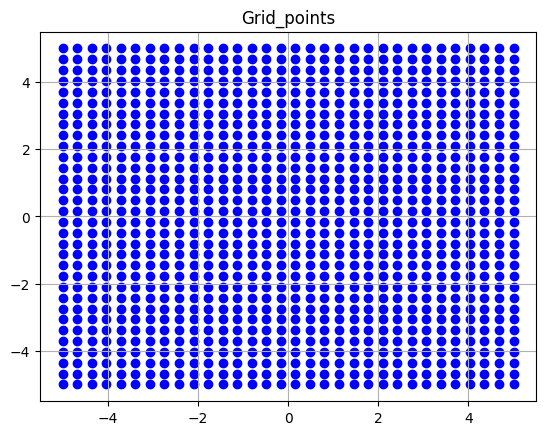

In [18]:
draw_data(grid_points.cpu(), title_str='Grid_points')
plt.grid(True)

## Gaussian data (1)

In [19]:
# generate a Gaussian data
dim = 2
datanum = 500
mean = np.array([0, 0])
cov = np.array([[.1,.01],[.01,.1]])

data1 = np.random.multivariate_normal(mean, cov, datanum)
data1 = torch.from_numpy(data1).float()

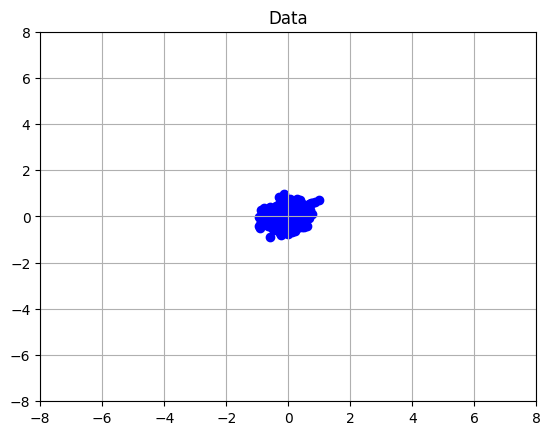

In [20]:
draw_data(data1.cpu(), title_str='Data')
lim = 8
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.grid(True)

In [ ]:
# _,v = make_vectors(d, data1, 1)
# vf = make_vector_field(grid_points, data1, v)
# vf = normalize_vector_field(vf)
# draw_vector_field(grid_points.cpu(), vf.cpu(), title_str="predicted vector field at t={}".format(1), scale=5)

### t = 1 에서만 Training - training_model_1

In [ ]:
# defining model
m1 = MyModel1()

In [ ]:
# 모델 학습 - training_model_1
epochs = 500

losses = training_model_1(epochs, grid_points, data1, d, m1, device=device)

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
print("Final loss: {}".format( losses[-1]))

In [ ]:
# diffused data (from t=0 to t=9) (비교용)
eta = torch.randn_like(data1).to(device)
x_curr = data1.to(device)
x_curr, v = make_vectors(d, x_curr, 1)

vf = make_vector_field(grid_points, data1, v)

vf = normalize_vector_field(vf)


draw_vector_field(grid_points.cpu(), vf.cpu(), title_str="diffused data - avg. vector field", scale=5)
# draw_vector_field(data1.cpu(), v.cpu(), title_str="diffused data - avg. vector field")
i = 0
for v in vf:
    if v.norm() > 0:
        i += 1
    
print(i)


In [ ]:
# MyModel prediction - training_model_1 결과
with torch.no_grad():
    outputs = m1(1)

    # draw_vector_field(grid_points.cpu(), outputs.cpu(), title_str="predicted vector field at t={}".format(1), scale=0.1)

    norms = torch.norm(outputs, p=2, dim=1, keepdim=True)
    print("outptus max: ", norms.max().item())
    print("outputs min: ", norms.min().item())
    print("outputs avg: ", norms.mean().item())
    
    normalized_out = normalize_vector_field(outputs)
    draw_vector_field(grid_points.cpu(), normalized_out.cpu(), lim=5.5, title_str="predicted vector field at t={}".format(1), scale=4)
    
    i = 0
    for v in normalized_out:
        if v.norm() > 0:
            i += 1
        
    print(i)

### 개별 t에 대한 MyModel1

In [ ]:
models = []
for t in range(d.n_steps):
    models.append(MyModel1())

In [ ]:
# 모델 학습 - training_model_1
epochs = 300

losses = training_model_4(epochs, grid_points, data1, d, models, device=device)

In [ ]:
# MyModel prediction - training_model_2 결과
t_slider = widgets.IntSlider(value=0, min=1, max=d.n_steps, step=1, description='t')
def update(t):
    with torch.no_grad():
        outputs = models[t-1](t)

        draw_vector_field(grid_points.cpu(), outputs.cpu(), lim=5, title_str="predicted vector field at t={}".format(t), scale=0.5)
        
        # normalized_out = normalize_vector_field(outputs)
        # draw_vector_field(grid_points.cpu(), normalized_out.cpu(), lim=5, title_str="predicted vector field at t={}".format(t), scale=5)
widgets.interact(update, t=t_slider)

### 개별 t에 대한 MyModel2

In [21]:
models = []
for t in range(d.n_steps):
    models.append(MyModel2(data1, datanum))

In [22]:
# 모델 학습 - training_model_1
epochs = 300

losses = training_model_4(epochs, grid_points, data1, d, models, device=device)

t: 10, epoch: 0, loss: 131.01815795898438
t: 10, epoch: 100, loss: 0.14710387587547302
t: 10, epoch: 200, loss: 0.06755396723747253


In [28]:
# MyModel prediction - training_model_2 결과
t_slider = widgets.IntSlider(value=0, min=1, max=d.n_steps, step=1, description='t')
def update(t):
    with torch.no_grad():
        outputs = models[t-1](t)
        normalized_out = normalize_vector_field(outputs)

        # draw_vector_field(grid_points.cpu(), outputs.cpu(), lim=5, title_str="predicted vector field at t={}".format(t), scale=0.1)
        draw_vector_field(grid_points.cpu(), normalized_out.cpu(), lim=5, title_str="predicted vector field at t={}".format(t), scale=5)
widgets.interact(update, t=t_slider)

interactive(children=(IntSlider(value=1, description='t', max=10, min=1), Output()), _dom_classes=('widget-int…

<function __main__.update(t)>

### 모든 t에 대해 Training - training_model_3 & MyModel2

In [ ]:
# defining model
m3 = MyModel2(data1, datanum)

In [ ]:
# 모델 학습 - training_model_3
epochs = 300

final_loss = training_model_3(epochs, grid_points, data1, d, m3, device=device)
print("final loss: {}".format(final_loss))

In [ ]:
# vector field of diffused data
t_slider = widgets.IntSlider(value=0, min=1, max=d.n_steps, step=1, description='t')
def update(t):
    with torch.no_grad():
        _,vec = make_vectors(d, data1.to(device), t)
        outputs = make_vector_field(grid_points, data1, vec)
        normalized_out = normalize_vector_field(outputs)

        # draw_vector_field(grid_points.cpu(), outputs.cpu(), lim=5, title_str="predicted vector field at t={}".format(t))
        draw_vector_field(grid_points.cpu(), normalized_out.cpu(), lim=5, title_str="predicted vector field at t={}".format(t), scale=5)
widgets.interact(update, t=t_slider)

In [ ]:
# MyModel2 prediction - training_model_2 결과
t_slider = widgets.IntSlider(value=0, min=1, max=d.n_steps, step=1, description='t')
def update(t):
    with torch.no_grad():
        outputs = m3(t)
        normalized_out = normalize_vector_field(outputs)

        # draw_vector_field(grid_points.cpu(), outputs.cpu(), lim=5, title_str="predicted vector field at t={}".format(t))
        draw_vector_field(grid_points.cpu(), normalized_out.cpu(), lim=5, title_str="predicted vector field at t={}".format(t), scale=5)
widgets.interact(update, t=t_slider)

### 기타 코드

In [ ]:
# PATH = './diffusive_flow.pth'
# torch.save(m.state_dict(), PATH)

## Gaussian data (2)

In [ ]:
# generate a Gaussian data
dim = 2
datanum = 500
mean = np.array([4.5, 0])
cov = np.array([[0, 2],[0, 2]])

data2 = np.random.multivariate_normal(mean, cov, datanum)
data2 = torch.from_numpy(data2).float()

In [ ]:
draw_data(data2.cpu(), title_str='Data2')
lim = 5
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)
plt.grid(True)

In [ ]:
# defining model
m4 = MyModel1()

In [ ]:
# 모델 학습
epochs = 500

training_model_3(epochs, grid_points, data2, d, m4, device=device)

In [ ]:
# plt.plot(range(epochs), losses)
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.show()

# print(losses[-1])

In [ ]:
# diffused data (from t=0 to t=9) (비교용)
eta = torch.randn_like(data2).to(device)
x_curr = data2.to(device)
# for t in range(n_steps):
#     x_curr, v = make_vectors(d, x_curr, t)
x_curr, v = make_vectors(d, x_curr, 1)

vf = make_vector_field(grid_points, data2, v)

# v = x_curr.to(device) - data2.to(device)
# normalized_v = normalize_vector_field(v)

draw_vector_field(grid_points.cpu(), vf.cpu(), title_str="diffused data - avg. vector field")
# draw_vector_field(data2.cpu(), normalized_v.cpu(), title_str="diffused data")
# draw_vector_field(data2.cpu(), v.cpu())
i = 0
for v in vf:
    if v.norm() > 0:
        i += 1
    
print(i)

In [ ]:
# MyModel prediction - training_model_2 결과
t_slider = widgets.IntSlider(value=0, min=0, max=d.n_steps-1, step=1, description='t')
def update(t):
    with torch.no_grad():
        outputs = m4(t)
        normalized_out = normalize_vector_field(outputs)

        # draw_vector_field(grid_points.cpu(), outputs.cpu(), lim=8, title_str="predicted vector field at t={}".format(t))
        draw_vector_field(grid_points.cpu(), normalized_out.cpu(), title_str="predicted vector field at t={}".format(t), scale=5)
widgets.interact(update, t=t_slider)